In [1]:
from scaling_law_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Plotting setup/parameters

In [2]:
all_data_sources = ['vanilla5',  'vanilla6', 'vanilla7', 'vanilla10', 'vanilla20',
                        'pfgmpp18', 'dg20', 'vanilla20dg20pfgmpp18']

# set up some variables affecting approach 1
approach_1_data_sources = all_data_sources
approach_1_flop_floor = 1.9e17

# set up some variables affecting approach 2
approach_2_base_dataset = 'dg20'
approach_2_datasets_to_learn_FID_params = ['vanilla7', 'vanilla10', 'vanilla20']

# set up some variables affecting approach 3
approach_3_models = None # fit to all models
approach_3_FID_modifies_E = True
approach_3_data_sources= all_data_sources

# set up some variables affecting multiple approaches
drop_small_models_on_large_data = True # this drops underfitting models by doing `data = data.query('not (params<100e6 & data>10e6 & FID<10)')`
loss_metric = 'CW_test_loss'
acc_metric = 'CW_test_acc'
data = pd.read_csv('AT_scaling_law_data.csv')
data.params = data.params*1e6
data.data_precise = data.data_precise*1e6
scale = get_scale_for_FLOPS_eq_NDscale(data)

In [3]:
ours_w_cifar = [
       'scaling_study_num_2_modelwrn-82-16-swish_data300_bs2048_lr0.1_fnvanilla20dg20pfgmpp18_withCIFARfrom4000to6000',
       'scaling_study_num_2_modelwrn-82-12-swish_data150_bs2048_lr0.2_fnvanilla20dg20pfgmpp18-150_unsup0.875',
       'scaling_study_num_2_modelwrn-58-12-swish_data175_bs2048_lr0.2_fnvanilla20dg20pfgmpp18-150_unsup0.875'
]
sota = ['scaling_study_num_2_modelwrn-94-16-swish_data500_bs2048_lr0.1_fnvanilla20dg20pfgmpp18_withCIFARfrom6000to10000',
]
ours_w_out_cifar = ['scaling_study_num_2_modelwrn-82-16-swish_data300_bs2048_lr0.1_fnvanilla20dg20pfgmpp18']
prior_sota = ['scaling_study_num_2_modelwrn-70-16-swish_data100_bs2048_lr0.2_fndg20']

bests = data.loc[data.groupby('config')['CW_test_loss'].idxmin()][[loss_metric, acc_metric, 'params', 'data_precise', 'FID', 'train_fraction','config','data_source','auto_attack']]
maxes = data.loc[data.groupby('config')['flops'].idxmax()][['config','flops']]
bests = pd.merge(bests,maxes)
bests.loc[bests.config.values==prior_sota[0],'auto_attack'] = 70.69
bests.loc[bests.config.values==prior_sota[0],'CW_test_acc'] = .7167 # From excel file sent to us by dm-improves-at authors
bests.query('config in @ours_w_cifar').groupby('config').max()

,CW_test_loss,CW_test_acc,params,data_precise,FID,train_fraction,data_source,auto_attack,flops
config,,,,,,,,,
scaling_study_num_2_modelwrn-58-12-swish_data175_bs2048_lr0.2_fnvanilla20dg20pfgmpp18-150_unsup0.875,0.725812,0.7179,122220000.0,179200000.0,1.4,1.000000,vanilla20dg20pfgmpp18_withCIFAR,70.85,1.717148e+20
scaling_study_num_2_modelwrn-82-12-swish_data150_bs2048_lr0.2_fnvanilla20dg20pfgmpp18-150_unsup0.875,0.716652,0.7205,177980000.0,153600000.0,1.4,0.975000,vanilla20dg20pfgmpp18_withCIFAR,71.41,2.148664e+20
scaling_study_num_2_modelwrn-82-16-swish_data300_bs2048_lr0.1_fnvanilla20dg20pfgmpp18_withCIFARfrom4000to6000,0.690983,0.7394,316360000.0,307200000.0,1.4,0.997333,vanilla20dg20pfgmpp18_withCIFAR,73.21,7.636654e+20


# Fitting - Approach 1

In [4]:
approach_1_analyses = {}

for data_source in approach_1_data_sources:
    temp = approach_1(data_source, return_analysis=True, flop_floor=approach_1_flop_floor, metric = loss_metric)
    temp.data = np.array([x*1e6 for x in temp.data])
    temp.params = np.array([x*1e6 for x in temp.params])
    approach_1_analyses[data_source] =temp

Analyzing data sources ['vanilla5']
Analyzing data sources ['vanilla6']
Analyzing data sources ['vanilla7']
Analyzing data sources ['vanilla10']
Analyzing data sources ['vanilla20']
Analyzing data sources ['pfgmpp18']
Analyzing data sources ['dg20']
Analyzing data sources ['vanilla20dg20pfgmpp18']


# Fitting - Approach 2

In [20]:
base_A, base_B, base_E, base_alpha, base_beta, base_a, base_b = approach_3([approach_2_base_dataset], drop_small_models_on_large_data=drop_small_models_on_large_data)
# hardcoding the following because they changed when nothing else changed, suggesting lbfgs noise
approach_2 = chinchilla_approach_3_FID_with_base(data_source=approach_2_datasets_to_learn_FID_params,
                            drop_small_models_on_large_data=drop_small_models_on_large_data,
                            base_params = (base_A, base_B, base_E, base_alpha, base_beta,
                           pd.read_csv('AT_scaling_law_data.csv').query('data_source==@approach_2_base_dataset').FID.unique().item()))
approach_2.fit()

Analyzing data sources ['dg20']
0 6.357828776041667e-08 10000000000.0 0.0010683827379190773
1000 0.24678337971369427 2.2260834263178864e-06 0.005226969072808158
2000 0.4372374971707662 2.205489042068528e-06 0.005226969072808158
3000 0.6436462481816609 2.205489042068528e-06 0.010899543465236302
3124 0.6689907153447469 2.205489042068528e-06 0.0012074536170238839
Analyzing data sources ['vanilla7' 'vanilla10' 'vanilla20']
0 9.934107462565105e-08 10000000000.0
11 0.0025772333145141603 3.213077492257977e-06


(6.686980024164729,
 7.551688897933183,
 0.5603731625795364,
 0.24434519315396275,
 0.2281458937440602,
 0.15552449537214338,
 -0.2767735799358655,
 (0.48285756085236076, 0.5171424391476392))

# Fitting - Approach 3

In [7]:
eq_1_5_fitter = Equation_1_5_That_Is_Chinchilla_At_FID0(data_source=approach_3_data_sources, model=approach_3_models,
                                                         drop_small_models_on_large_data=True, FID_modifies_E=approach_3_FID_modifies_E)
eq_1_5_fitter.fit()

Analyzing data sources ['vanilla5' 'vanilla6' 'vanilla7' 'vanilla10' 'vanilla20' 'pfgmpp18'
 'dg20' 'vanilla20dg20pfgmpp18']
0 1.1920928955078125e-07 10000000000.0


/Users/bartoldson1/Adversarial-Robustness-Limits/scaling_law_utils.py:549: RuntimeWarning: invalid value encountered in power
  beta * np.log((B/D) + (Q*FID)**(kappa/beta)),
/Users/bartoldson1/Adversarial-Robustness-Limits/scaling_law_utils.py:550: RuntimeWarning: invalid value encountered in log
  np.log(E),
/Users/bartoldson1/Adversarial-Robustness-Limits/scaling_law_utils.py:551: RuntimeWarning: invalid value encountered in log
  np.log(A) - alpha * np.log(N)
/Users/bartoldson1/mambaforge/envs/plot/lib/python3.11/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


647 0.28354088465372723 3.912597572438895e-06


array([6.00080741e+00, 7.00000000e+03, 5.15022255e-01, 6.59350845e-03,
       2.41841188e-01, 2.17406245e-01, 6.04209556e-01, 3.57334903e-02])

In [9]:
approach_3_ND_star_dict = {}
i=0
data_sources=all_data_sources + ['fid0']
for FLOPs in [10**17, 10**18, 10**19, 10**20, 10**21, 10**22, 10**23, 10**24]:
    for data_source in data_sources:
        i+=1
        override_FID = None
        if data_source=='fid0': 
            override_FID=0
        d = eq_1_5_fitter.get_D_star_N_star(FLOPs,data_source,override_FID=override_FID)
        approach_3_ND_star_dict[i] = d
approach_3_ND_star = pd.DataFrame(approach_3_ND_star_dict).transpose()

/Users/bartoldson1/mambaforge/envs/plot/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/Users/bartoldson1/mambaforge/envs/plot/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/Users/bartoldson1/mambaforge/envs/plot/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/bartoldson1/mambaforge/envs/plot/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg,

# Figure - Teaser

In [21]:
# Parameters
fid0_line = False
second_set = 'dg20'
first_set = ['vanilla7'] #[]
font_size = 13.5
match_scaling_color = True
extrapolated_max = 30
human_best = .9046
scaling_text = 'Raise synthetic dataset quality to be here.'
human_text = 'Humans disagree with adversarial data labels here.'
scaling_text = r"$\bullet$"+'Area is unreachable with SOTA generative models.\n'+r"$\bullet$"+'Improve quality of synthetic training data to reach this area.'
human_text = r"$\bullet$"+"Humans disagree with adversarial data labels here.\n"+r"$\bullet$"+"Account for attack's validity, not just its"+r" $\ell_p$ norm, to reach this area."
scaling_text = 'Improve generative models to reach here.'
human_text = 'Fix attack models to reach here.'
xpos = 10**(17+(extrapolated_max-17)/2)
xpos_fix = xpos
ypos_fix = 0.872 + 0.001
xpos_fix_human =xpos
align_for_fix = 'center' #'left'
align_for_fix_human = 'center'

Analyzing data sources ['vanilla5']
6.7908 0.7531463613146835 1e+30
Analyzing data sources ['vanilla5']
1.65 0.8285778530148242 1e+30
Analyzing data sources ['vanilla5']
0 0.8863254780257899 1e+30
0.8965242471325952 0.9046
2.1e+25
4.02e+22
5.76e+23


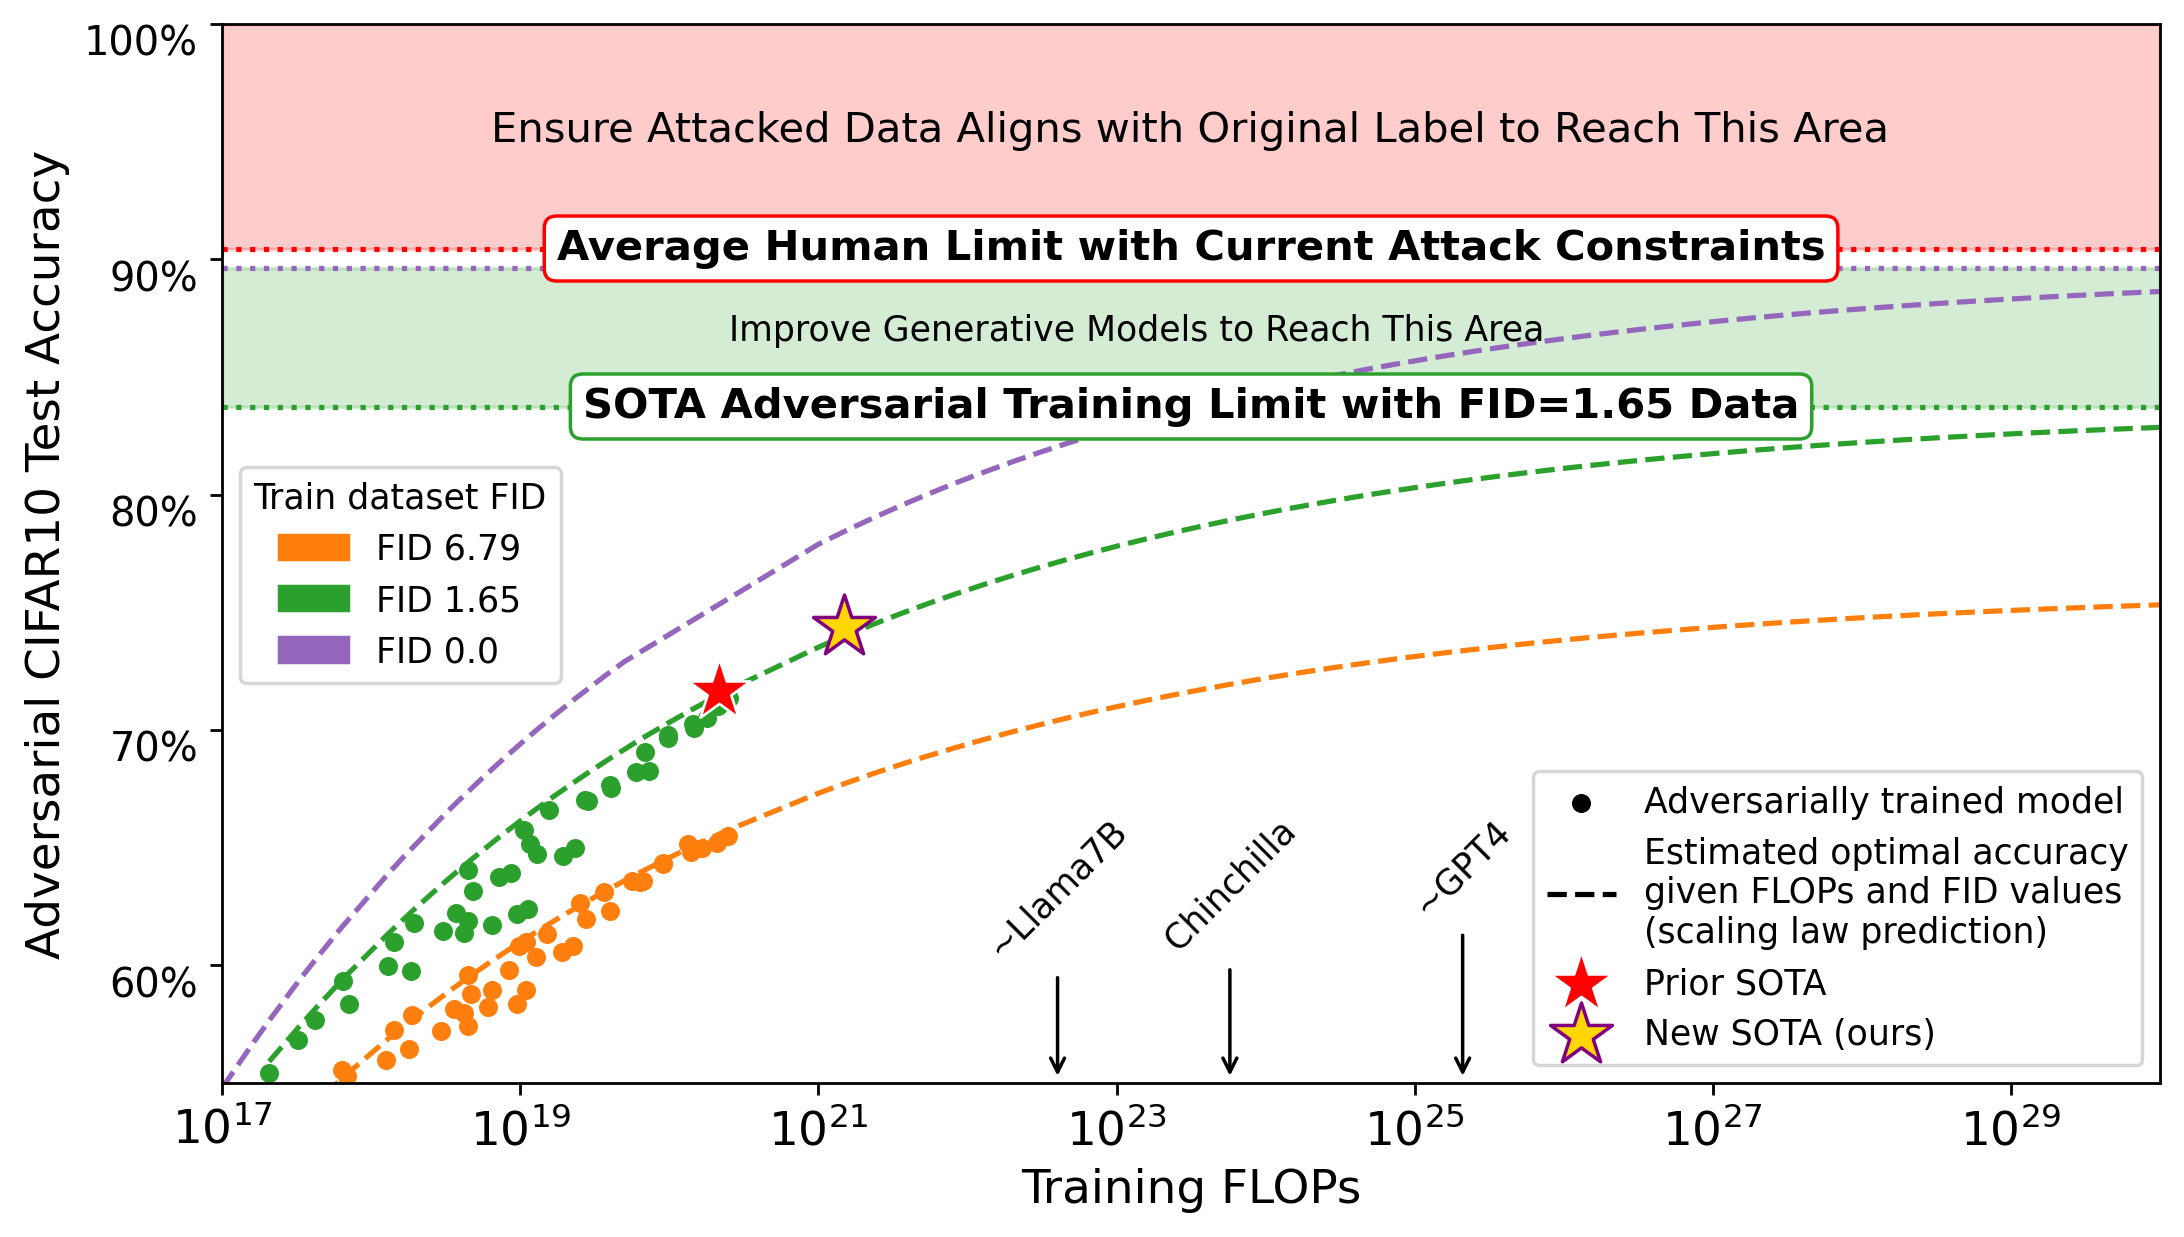

In [22]:
plt.figure(figsize=(10, 5.5), dpi=250)

loss_vals, acc_vals, N, D, F, FID, tf = bests.query('data_source=="dg20"').drop(columns=['config','data_source','auto_attack']).values.T
acc_reg = linregress(loss_vals,acc_vals)

data_sources = first_set + [second_set,'infCIFAR']
fid_dict = data[['data_source','FID']].drop_duplicates().set_index('data_source').to_dict()['FID']
fid_dict['infCIFAR'] = 0
FIDs = np.array([fid_dict[d] for d in data_sources])
idx = np.argsort(FIDs)[::-1]
FIDs = FIDs[idx]
data_sources = np.array(data_sources)[idx]

c_dict = {}

for i, data_source in enumerate(data_sources):
    if data_source=='infCIFAR':
        continue
    L, N, D, F, FID = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
    acc_pred = acc_reg.slope*L + acc_reg.intercept
    if i==0:
        label = f'Adversarially trained model'
    else:
        label = None
    plt.scatter(F, acc_pred, s=20, label=label, c=f'C{i+1}')
    
for i, data_source in enumerate(data_sources):
    if data_source=='infCIFAR':
        L, N, D, F, FID = get_LNDFlopsFID_at_optimum(data, data_source='vanilla5', metric='CW_test_loss')
        FID = [0] + [0]*len(FID)
        F = np.array([10.**17] + list(F))
    else:
        L, N, D, F, FID = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
    extrapolated = np.logspace(21,extrapolated_max)
    F = np.concatenate((F,extrapolated))
    FID = np.concatenate((FID,np.array([FID[0]]*len(extrapolated))))

    #override fid so data source doesn't matter here
    l_hat = approach_2.get_D_star_N_star(F, 'vanilla5', override_FID=FID[0])['l_hat_star']
    idx = np.argsort(F)
    F = F[idx]
    l_hat = l_hat[idx]
    acc_pred = acc_reg.slope*l_hat + acc_reg.intercept
    if i==0:
        label = "Estimated optimal accuracy\ngiven FLOPs and FID values\n(scaling law prediction)"
    else:
        label = None
    
    l,  = plt.plot(F, acc_pred, linestyle='--',label=label, c=f'C{[1,2,4,5][i]}')
    c_dict[FID[0]] = l.get_color()
    print(FID[0], max(acc_pred), max(F))

ax = plt.gca()
assert second_set in data_sources
scaling_asymptote_loss = approach_2.FID_with_base_modifier(approach_2.E, approach_2.FID_e, 0, log_first=True)
scaling_asymptote = acc_reg.slope*scaling_asymptote_loss + acc_reg.intercept
print(scaling_asymptote, human_best)
scaling_asymptote_loss_second = approach_2.FID_with_base_modifier(approach_2.E, approach_2.FID_e, fid_dict[second_set], log_first=True)
scaling_asymptote_second = acc_reg.slope*scaling_asymptote_loss_second + acc_reg.intercept




if fid0_line: xpos = 10.**24.8
# Adding a red dotted line at y=0.9 with label
ax.axhline(y=human_best, color='r', linestyle=':')
# Shading the area above the red line in light red
ax.fill_betweenx([human_best, 1], 10.**17, 10.**extrapolated_max, color='red', alpha=0.2)
# Adding a text box in the shaded area
ax.text(10**18.8, 0.955, 'Ensure Attacked Data Aligns with Original Label to Reach This Area' , horizontalalignment='left', verticalalignment='center', fontsize=12
        )
ax.text(xpos, human_best, 'Average Human Limit with Current Attack Constraints', horizontalalignment='center', verticalalignment='center', 
        color='black', backgroundcolor='white', fontsize=12, fontweight='bold',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))

if fid0_line:
    # Adding a red dotted line at y=0.9 with label
    ax.axhline(y=scaling_asymptote, color='b', linestyle=':')
    # Shading the area above the red line in light red
    ax.fill_betweenx([scaling_asymptote, human_best], 10.**17, 10.**extrapolated_max, color='blue', alpha=0.2)
    ax.text(10.**17.1, scaling_asymptote, 'Scaling Law Asymptote (FID=0)', horizontalalignment='left', verticalalignment='center', 
            color='black', backgroundcolor='white', fontsize=12, fontweight='bold',  bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))
    #ax.text(10.**22, 0.87, 'Better models/data are needed here', horizontalalignment='center', verticalalignment='center', )


scaling_color = 'blue'
if match_scaling_color: scaling_color = c_dict[fid_dict[second_set]]
# Adding a red dotted line at y=0.9 with label
ax.axhline(y=scaling_asymptote_second, color=scaling_color, linestyle=':')
# Shading the area above the red line in light red
ax.fill_betweenx([scaling_asymptote_second, scaling_asymptote], 10.**17, 10.**extrapolated_max, color=scaling_color, alpha=0.2)
ax.text(xpos, scaling_asymptote_second, f'SOTA Adversarial Training Limit with FID={fid_dict[second_set]} Data', horizontalalignment='center', verticalalignment='center', 
        color='black', backgroundcolor='white', fontsize=12, fontweight='bold',  bbox=dict(facecolor='white', edgecolor=scaling_color, boxstyle='round'))
ax.text(10**20.4, ypos_fix-0.003, 'Improve Generative Models to Reach This Area', horizontalalignment='left', verticalalignment='center', fontsize=10, zorder=100000, linespacing=0.85
        #bbox=dict(facecolor=scaling_color, edgecolor='None',alpha=0.82, boxstyle='round',pad=0)
        )

ax.axhline(y=scaling_asymptote, color= c_dict[fid_dict['infCIFAR']], linestyle=':')

plt.scatter([bests.query('config==@s')['flops'].item() for s in prior_sota],
               [bests.query('config==@s')[acc_metric].item() for s in prior_sota],
               s=350, marker='*', c='red', label= 'Prior SOTA', edgecolors='white',linewidth=.75,zorder=50)
plt.scatter([bests.query('config==@s')['flops'].item() for s in sota],
               [bests.query('config==@s')[acc_metric].item() for s in sota],
               s=350, marker='*', c='gold', label='New SOTA (ours)', edgecolors='purple',zorder=50)

l = plt.legend(loc='lower right')
if first_set:
    for line in l.legendHandles[:2]:
        line.set_color('black')
plt.xscale('log')
plt.ylim(0.55,1)
plt.xlim(10.**17,10.**extrapolated_max)
plt.ylabel('Adversarial CIFAR10 Test Accuracy')
plt.xlabel("Training FLOPs")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
for item in ax.get_yticklabels():
    item.set_fontsize(font_size-2)
ax.set_yticks([.6,.7,.8,.9,1])
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick
ax.set_yticklabels([str(int(float(label.get_text())*100))+'%' for label in ax.get_yticklabels()])
handles, labels = ax.get_legend_handles_labels()

# Create a second legend with color blobs and text
colors = [c_dict[f] for f in FIDs]  # List of colors for the blobs
texts = [f'FID {round(f,2)}' for f in FIDs]  # Corresponding text for each blob
# Create a list of patches as legend handles
patches = [Patch(color=color, label=text) for color, text in zip(colors, texts)]
# Add the second legend to the plot
second_legend = ax.legend(handles=patches, loc='center left')
second_legend.set_title("Train dataset FID")
second_legend.set_bbox_to_anchor((0,.48))
# Manually add the first legend back after the second one has been created
ax.add_artist(l)

comparisons = {
    '~GPT4' : 2.1e25,
    '~Llama7B' : 6.7*6*1e12*1e9,
    'Chinchilla' : 5.76e23
}

annotate = True
if annotate:
    for i, annotation in enumerate(comparisons):
        print(comparisons[annotation])
        plt.annotate(annotation, 
                 xy=(comparisons[annotation], .55), 
                 xytext=(comparisons[annotation], .665),
                 arrowprops=dict(facecolor='black', arrowstyle="->"),
                 horizontalalignment='center', 
                 verticalalignment='top', 
                 rotation=45)

plt.show()

# Figure - Approach 1

In [12]:
# Parameters
data_source = 'pfgmpp18'
analysis = approach_1_analyses[data_source]
extend_to_large_runs = True
show_sota = False
font_size = 14
palette = 'viridis'
x_start = 10.**16.5


$R^2:{0.991}$

$R^2:{0.846}$


/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/361928637.py:100: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(flops,
/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/361928637.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(x)}M' if x<1000 else f'{int(x/1e3)}B' for x in ax.get_yticks()/1e6])
/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/361928637.py:129: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(flops,



$R^2:{0.765}$


/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/361928637.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(x)}M' if x<1000 else f'{int(x/1e3)}B' for x in ax.get_yticks()/1e6])


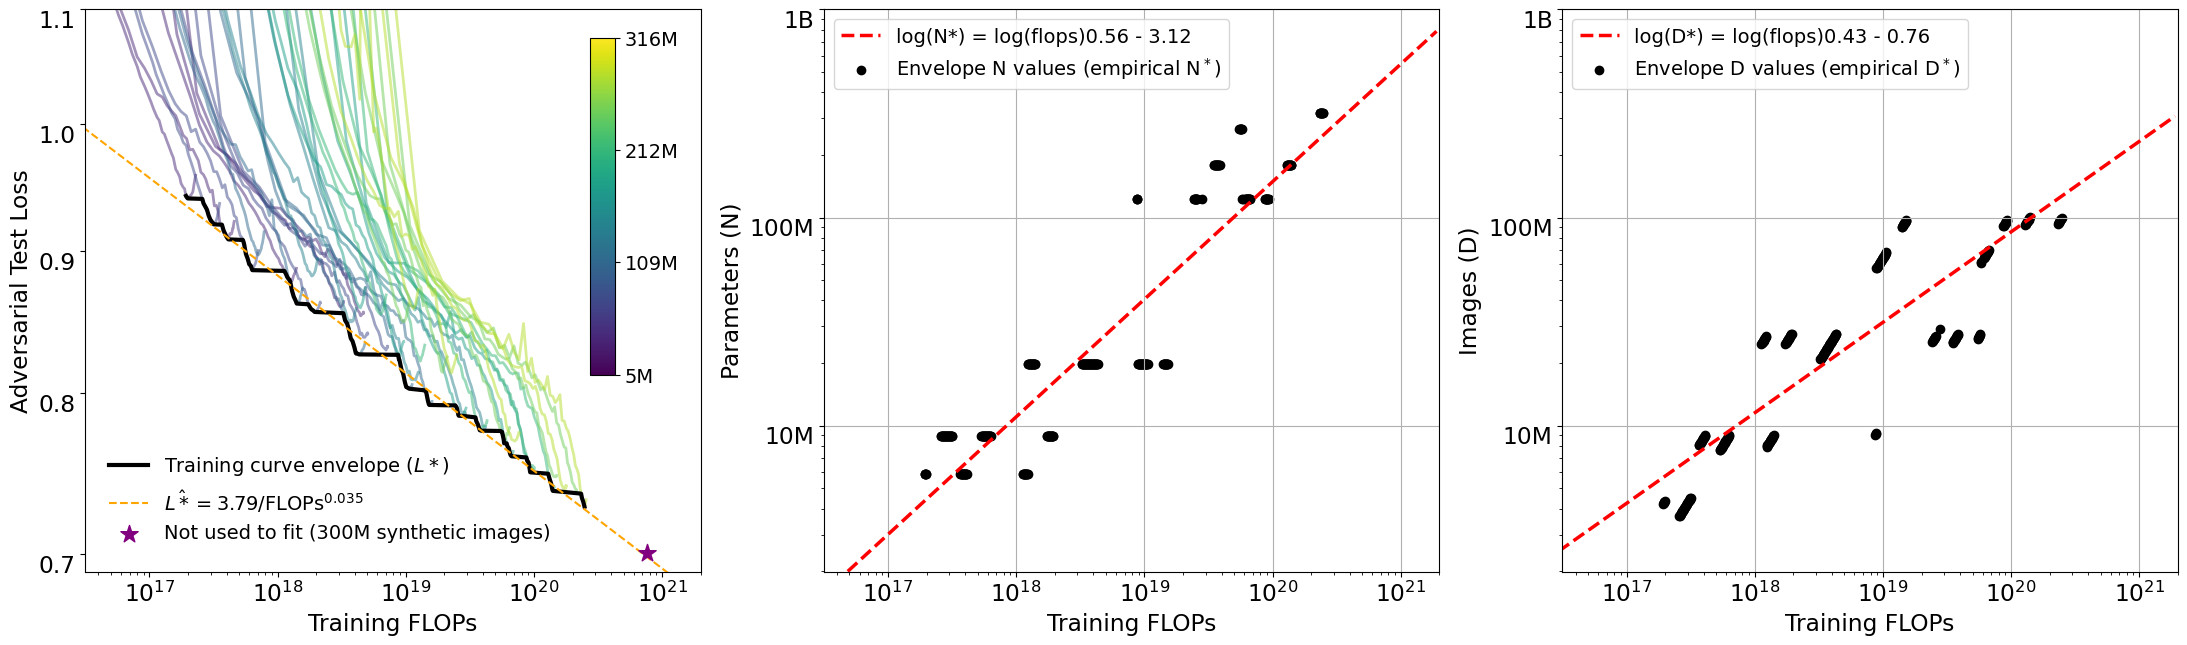

In [13]:
fig = plt.figure(figsize=(9*3, 7.3))

plt.subplot(1,3,1)

params = data.query('data_source==@data_source').params.unique()
c_dict = { d:c for d,c in zip(params, 
                              sns.color_palette(palette, len(params)))
}

for i, c in enumerate(data.query('data_source==@data_source').config.unique()):
    plt.plot(data[data.config==c].flops,
            data[data.config==c][loss_metric], alpha=0.5, c = c_dict[data[data.config==c].params.unique().item()], linewidth=2)


ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=sns.color_palette(palette, len(params), as_cmap=True),
                           norm=plt.Normalize(vmin=params[0], vmax=params[-1]))
sm._A = []
cbar = plt.colorbar(sm,ticks=np.linspace(params[0],params[-1],4),   cax=ax.inset_axes((0.82, 0.35, 0.04, 0.6)))
cbar.set_ticklabels([f'{int(p/1e6)}M' for p in cbar.get_ticks()])
cbar.ax.tick_params(labelsize=font_size)


plt.plot(analysis.flops, analysis.bests, c='black', label=r'Training curve envelope ($L*$)', linewidth=3)

reg = linregress(np.log(analysis.flops), np.log(analysis.bests))
D_regression = linregress(np.log10(analysis.flops), np.log10(analysis.data))
N_regression = linregress(np.log10(analysis.flops), np.log10(analysis.params))

flops = [10.**16] + analysis.flops
if extend_to_large_runs:
    flops = flops+[1.9*10**21]

loss_pred = np.exp((reg.slope)*(np.log(flops)) + reg.intercept)

print(f'\n$R^2:{{{reg.rvalue**2:.3f}}}$')
plt.plot(np.array(flops), 
         loss_pred, c='orange',
         linestyle='--',
         label=f'$\hat{{{"L*"}}} = {np.exp(reg.intercept):.2f}/$FLOPs$^{{{-reg.slope:.3f}}}$')
plt.ylabel(loss_metric)
plt.xlabel('FLOPs')
#plt.title(f'Chinchilla Approach 1: Best {loss_metric.replace("_"," ")} at each FLOP count')
plt.xscale('log')

if extend_to_large_runs:
    if show_sota:
        plt.scatter([bests.query('config==@s').flops.item() for s in ours_w_cifar],
                    [bests.query('config==@s')[loss_metric].item() for s in ours_w_cifar],
                    s=120, marker='*', c='purple', label='Ours')
        plt.scatter([bests.query('config==@s').flops.item() for s in prior_sota],
                    [bests.query('config==@s')[loss_metric].item() for s in prior_sota],
                    s=120, marker='*', c='red', label= 'Prior SOTA')
        plt.scatter([bests.query('config==@s').flops.item() for s in sota],
                    [bests.query('config==@s')[loss_metric].item() for s in sota],
                    s=120, marker='*', c='gold', label='New SOTA (Ours)', edgecolors='purple')
        plt.annotate("20% fewer FLOPs &\nBetter AutoAttack\nThan Prior SOTA", xy=(2*10**20, 0.725), xytext=(1.*10**19,.7), arrowprops=dict(arrowstyle="->"))
    plt.scatter([bests.query('config==@s').flops.item() for s in ours_w_out_cifar],
                [bests.query('config==@s')[loss_metric].item() for s in ours_w_out_cifar],
                s=170, marker='*', c='purple', label='Not used to fit (300M synthetic images)',zorder=50)
    
    
l=plt.legend(loc='lower left', prop={'size': font_size}, frameon=False, bbox_to_anchor=[0.01, 0.02])
# Remove the first legend from the current axes
#plt.gca().add_artist(l)
    
if loss_metric =='CW_test_loss':
    plt.ylabel("Adversarial Test Loss")
    plt.xlabel("Training FLOPs")
else:
    plt.ylabel(r"$\bf{Test\ Loss}$"+'\nafter PGD-40 Attack on Cross-Entropy Loss')
    plt.xlabel("Training FLOPs")

if extend_to_large_runs:
    #l2 = plt.legend(loc='upper right')
    #handles, labels = l2.legendHandles, [text.get_text() for text in l2.get_texts()]
    #new_handles = handles[3:]
    #new_labels = labels[3:]
    #l2.remove()
    #plt.legend(new_handles, new_labels, loc='upper right')
    plt.xlim(x_start,2*10.**21)
else:
    plt.xlim(x_start,3*10.**20)
plt.ylim(.69,1.1)
plt.yscale('log')
plt.yticks([.7,.8,.9,1,1.1], [0.7, 0.8, 0.9, 1.0,1.1])
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size*1.2)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick




plt.subplot(1,3,2)
pred = np.power(10, N_regression.slope*np.log10(flops) + N_regression.intercept)
print(f'\n$R^2:{{{N_regression.rvalue**2:.3f}}}$')
plt.plot(flops, 
         pred, 'r-',
         linestyle='--',
         linewidth=2.5,
         label=f'log(N*) = log(flops){round(N_regression.slope,2)}{" + " if N_regression.intercept>0 else " - "}{abs(round(N_regression.intercept,2))}')
plt.scatter(analysis.flops, analysis.params, label=r'Envelope N values (empirical N$^*$)',
         c = 'black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training FLOPs")
plt.ylabel("Parameters (N)")
plt.legend(loc='upper left', fontsize=font_size)
plt.grid()
plt.xlim(x_start, 2*10.**21)
plt.ylim(10.**(int(np.log10(analysis.params.min()))+0.3), 10.**(int(np.log10(analysis.params.max()))+1))
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size*1.2)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick
ax.set_yticklabels([f'{int(x)}M' if x<1000 else f'{int(x/1e3)}B' for x in ax.get_yticks()/1e6])




plt.subplot(1,3,3)
pred = np.power(10, D_regression.slope*np.log10(flops) + D_regression.intercept)
print(f'\n$R^2:{{{D_regression.rvalue**2:.3f}}}$')
plt.plot(flops, 
         pred, 'r-',
         linestyle='--',
         linewidth=2.5,
         label=f'log(D*) = log(flops){round(D_regression.slope,2)}{" + " if D_regression.intercept>0 else " - "}{abs(round(D_regression.intercept,2))}')
plt.scatter(analysis.flops, analysis.data, label=r'Envelope D values (empirical D$^*$)',
         c = 'black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training FLOPs")
plt.ylabel("Images (D)")
plt.legend(loc='upper left', fontsize=font_size)
plt.grid()
plt.xlim(x_start, 2*10.**21)
plt.ylim(10.**(int(np.log10(analysis.data.min()))+0.3), 10.**(int(np.log10(analysis.data.max()))+1))
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size*1.2)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick
    
ax.set_yticklabels([f'{int(x)}M' if x<1000 else f'{int(x/1e3)}B' for x in ax.get_yticks()/1e6])

plt.show()

# Figures - Approach 2

In [23]:
# Parameters
data_source = 'dg20'
approach_2_data_sources = [  'vanilla6', 'vanilla7', 'vanilla10', 'vanilla20', 'pfgmpp18', 'dg20' ]
font_size = 13.5

/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/4044096363.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=[x for x in ax.levels[::5][:-1]], pad=0, shrink=.553)
/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/4044096363.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([fr'$10^{{{int(x)}}}$'  for x in ax.get_xticks()])


Analyzing data sources ['vanilla5']


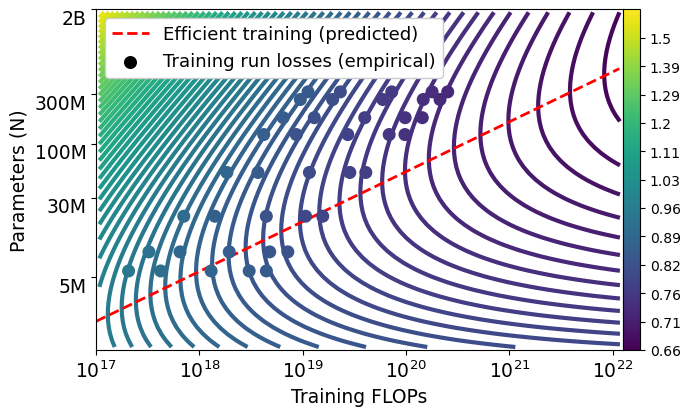

In [24]:
fig = plt.figure(figsize=(8, 8))


FID =  data.query('data_source==@data_source').FID.values[0]

min_n_exp, max_n_exp = int(np.log10(data.params.min())), np.log10(2e9)# model sizes
ns = 10 ** np.arange(min_n_exp, max_n_exp, step=2**-4) 
min_f_exp, max_f_exp = 17, 22.1
fs = 10 ** np.arange(min_f_exp, max_f_exp, step=2**-4) 
min_d_exp, max_d_exp = int(np.log10(data.data_precise.min())), int(np.log10(data.data_precise.max()))+1.5 # dataset sizes
ds = 10 ** np.arange(min_d_exp, max_d_exp, step=2**-4) 

# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds
loss2d = (np.array([[np.log(approach_2.L_hat(n, nf_to_d(n,f, scale=scale),FID)) for f in fs] for n in ns]))
ax = plt.gca().imshow(loss2d, extent=[min_f_exp, max_f_exp, min_n_exp, max_n_exp], origin='lower',alpha=0)
ax = plt.contour(loss2d, levels=70, extent=[min_f_exp, max_f_exp, min_n_exp, max_n_exp], origin='lower', linewidths=3)
plt.xlabel('Training FLOPs')
plt.ylabel('Parameters (N)')

norm= mcolors.Normalize(vmin=ax.cvalues.min(), vmax=ax.cvalues.max())
# a previous version of this used
#norm= matplotlib.colors.Normalize(vmin=cs.vmin, vmax=cs.vmax)
# which does not work any more
sm = plt.cm.ScalarMappable(norm=norm, cmap = ax.cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ticks=[x for x in ax.levels[::5][:-1]], pad=0, shrink=.553)
cbar.set_ticklabels([round(x,2) for x in np.exp(cbar.get_ticks())])
#cbar = plt.colorbar(ax, pad=0, shrink=.588)
#norm = plt.Normalize(vmin=loss2d.min(), vmax=loss2d.max())

plt.plot(np.log10(fs), np.log10(approach_2.get_D_star_N_star(fs, 'vanilla5', override_FID=FID)['N_star']), label='Efficient training (predicted)', linewidth=2,  linestyle='--', c='red')
L, N, D, F, _ = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
plt.scatter(np.log10(F), np.log10(N), s=70, label='Training run losses (empirical)', c=cbar.cmap(norm(np.log(L))), zorder=500)

legend =plt.legend(fontsize=13,loc='upper left')
legend.get_frame().set_alpha(None)
for line in legend.legendHandles[1:2]:
    line.set_color('black')
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick


plt.yticks(np.log10([5.1e6, 30e6, 100e6, 300e6, 2e9]))
plt.ylim(np.log10(1e6),np.log10(2e9))
ax.set_yticklabels([f'{int(10**x)}M' if x<3 else f'{int(10**x/1e3)}B' for x in ax.get_yticks()-6])
ax.set_xticklabels([fr'$10^{{{int(x)}}}$'  for x in ax.get_xticks()])
plt.show()

/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/3931191073.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=[x for x in ax.levels[::5]], pad=0, shrink=.553)
/var/folders/76/wt_1qhxd2l79335j0pd06tv0000s_v/T/ipykernel_66377/3931191073.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([fr'$10^{{{int(x)}}}$'  for x in ax.get_xticks()])


Analyzing data sources ['vanilla5']


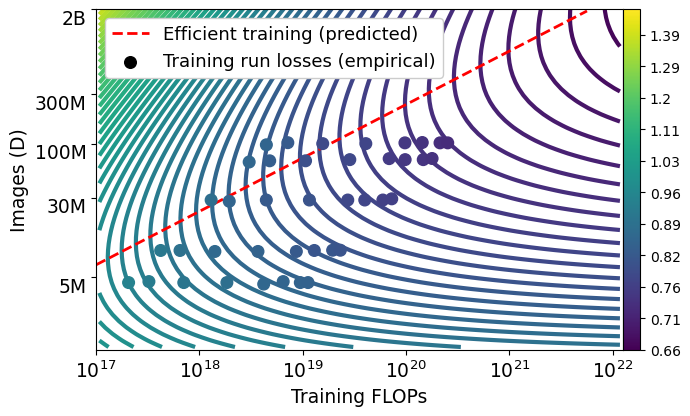

In [25]:
fig = plt.figure(figsize=(8, 8))

# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds
loss2d = (np.array([[np.log(approach_2.L_hat(df_to_n(d,f, scale=scale), d, FID)) for f in fs] for d in ds]))
ax = plt.gca().imshow(loss2d, extent=[min_f_exp, max_f_exp, min_d_exp, max_d_exp], origin='lower', alpha=0.0)
ax = plt.contour(loss2d, levels=72, extent=[min_f_exp, max_f_exp, min_d_exp, max_d_exp], origin='lower', linewidths=3)
plt.xlabel('Training FLOPs')
plt.ylabel('Images (D)')

norm= mcolors.Normalize(vmin=ax.cvalues.min(), vmax=ax.cvalues.max())
# a previous version of this used
#norm= matplotlib.colors.Normalize(vmin=cs.vmin, vmax=cs.vmax)
# which does not work any more
sm = plt.cm.ScalarMappable(norm=norm, cmap = ax.cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ticks=[x for x in ax.levels[::5]], pad=0, shrink=.553)
cbar.set_ticklabels([round(x,2) for x in np.exp(cbar.get_ticks())])
#cbar = plt.colorbar(ax, pad=0, shrink=.588)
#norm = plt.Normalize(vmin=loss2d.min(), vmax=loss2d.max())

plt.plot(np.log10(fs)[np.log10(fs)<21.8], np.log10(approach_2.get_D_star_N_star(fs, 'vanilla5', override_FID=FID)['D_star'])[np.log10(fs)<21.8], label='Efficient training (predicted)', linewidth=2,  linestyle='--', c='red')
L, N, D, F, _ = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
plt.scatter(np.log10(F), np.log10(D), s=70, label='Training run losses (empirical)', c=cbar.cmap(norm(np.log(L))), zorder=500)

legend =plt.legend(fontsize=13,loc='upper left')
legend.get_frame().set_alpha(None)
for line in legend.legendHandles[1:2]:
    line.set_color('black')
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick


plt.yticks(np.log10([5.1e6, 30e6, 100e6, 300e6, 2e9]))
plt.ylim(np.log10(1e6),np.log10(2e9))
ax.set_yticklabels([f'{int(10**x)}M' if x<3 else f'{int(10**x/1e3)}B' for x in ax.get_yticks()-6])
ax.set_xticklabels([fr'$10^{{{int(x)}}}$'  for x in ax.get_xticks()])
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

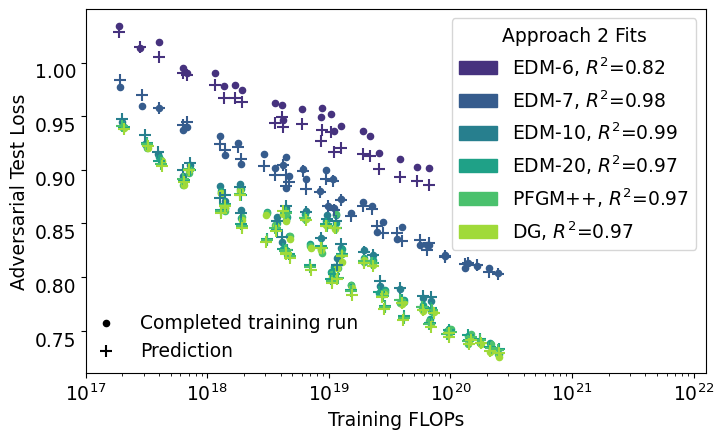

In [26]:
fig = plt.figure(figsize=(8, 4.73))

# Show fit on different datasets
c_dict = { d:c for d,c in zip(approach_2_data_sources, 
                              sns.color_palette('viridis', len(approach_2_data_sources)))
}

for data_source in approach_2_data_sources:
    L, N, D, F, FID = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
    plt.scatter(F, L, s=20, c=c_dict[data_source], label='Actual') #, facecolors='none')
    
r2_dict  = {}
for data_source in approach_2_data_sources:
    L, N, D, F, FID = get_LNDFlopsFID_at_optimum(data, data_source=data_source, metric='CW_test_loss')
    l_hat = approach_2.L_hat(N, D, FID) 
    r2 = R2(l_hat, L)
    r2_dict[data_source] = r2
    plt.scatter(F, l_hat, s=65,  marker='+',
                    label=data_source.replace('vanilla','EDM-').replace('dg20','DG').replace('pfgmpp18','PFGM++')+', '+r'$R^2$='+f'{round(r2,2)}',
                     c=c_dict[data_source])


plt.xlabel('Training FLOPs')
plt.ylabel('Adversarial Test Loss')
l = plt.legend(loc='lower left', fontsize=font_size)
plt.xscale('log')
plt.xlim(10.**17, 10.**22.1)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
for line in l.legendHandles:
    line.set_color('black')
new_labels = []
new_handles = []
text = 'Completed training run'
for handle, label in zip(l.legendHandles[::len(approach_2_data_sources)], l.texts[::len(approach_2_data_sources)]):
    new_handles.append(handle)
    new_labels.append(text)
    text = 'Prediction'

# Update the legend
l.remove()  # Remove the old legend
l = plt.legend(new_handles, new_labels, loc='lower left', fontsize=font_size, frameon=False, bbox_to_anchor=(-0.025,-0.01))

# Create a second legend with color blobs and text
colors = [c_dict[f] for f in approach_2_data_sources]  # List of colors for the blobs
texts = [data_source.replace('vanilla','EDM-').replace('dg20','DG').replace('pfgmpp18','PFGM++')+', '+r'$R^2$='+f'{round(r2_dict[data_source],2)}' for data_source in approach_2_data_sources]  # Corresponding text for each blob
# Create a list of patches as legend handles
patches = [Patch(color=color, label=text) for color, text in zip(colors, texts)]
# Add the second legend to the plot
second_legend = ax.legend(handles=patches, loc='upper right', fontsize=font_size)
second_legend.set_title("Approach 2 Fits")
# Manually add the first legend back after the second one has been created

ax.add_artist(l)

second_legend.get_title().set_fontsize(str(font_size))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
for label in ax.get_yticklabels():
    label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick




plt.show()

# Figure - Approach 3

In [18]:
# Parameters
font_size = 13.5

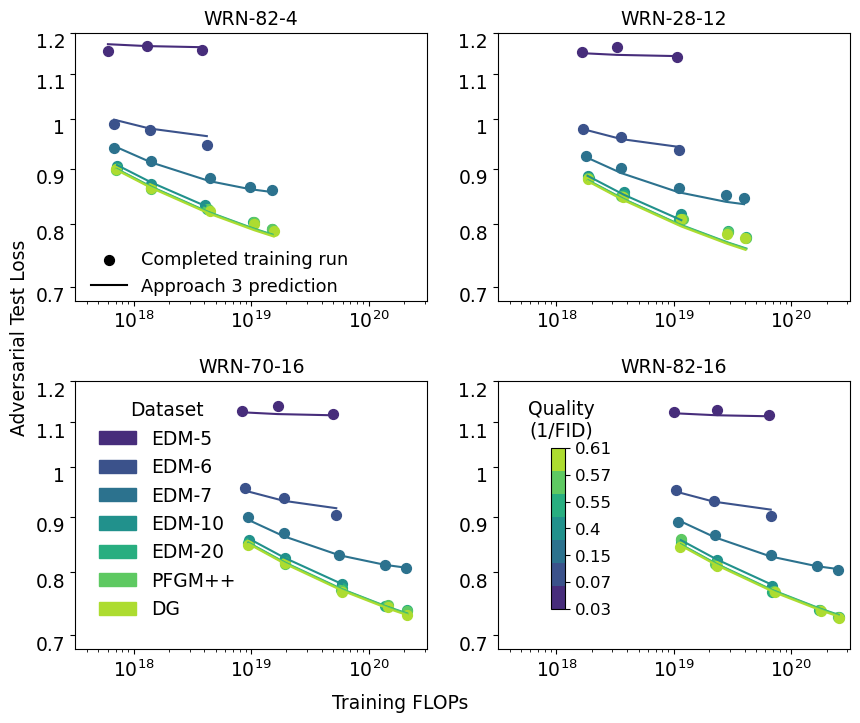

In [19]:
models =  ['wrn-82-4-swish','wrn-28-12-swish', 'wrn-70-16-swish',  'wrn-82-16-swish']

fig, ax = plt.subplots(nrows=2, ncols=2)
plt.gcf().set_size_inches(10,8)

data_sources = [d for d in approach_3_data_sources if d!='vanilla20dg20pfgmpp18']

fid_dict = data[['data_source','FID']].drop_duplicates().set_index('data_source').to_dict()['FID']
FIDs = np.array([fid_dict[d] for d in data_sources])
idx = np.argsort(FIDs)[::-1]
FIDs = FIDs[idx]
data_sources = np.array(data_sources)[idx]

c_dict = { d:c for d,c in zip(data_sources, 
                              sns.color_palette('viridis', len(data_sources)))
}

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        model = models[i*len(row)+j]
        temp_data = data.query('train_fraction>0.5').query('model==@model')

        if i==0 and j==0:
            # Adding an invisible point for the legend (matching scatter plot styling)
            col.scatter([], [], s=50, color='black', label='Completed training run')
            col.plot([], [],  color='black',         label='Approach 3 prediction', linewidth=1.5)
            # Add the legend to the plot
            col.legend(loc='lower left',frameon=False,fontsize=.95*font_size, bbox_to_anchor=(.00, -.04))

        for data_source in data_sources:
            L, N, D, F, FID = get_LNDFlopsFID_at_optimum(temp_data, data_source=data_source, metric='CW_test_loss')
            im = col.scatter((F), L, s=50, label=data_source + ' act.', c=[c_dict[data_source]])
            
        for data_source in data_sources:
            L, N, D, F, FID = get_LNDFlopsFID_at_optimum(temp_data, data_source=data_source, metric='CW_test_loss')
            l_hat = eq_1_5_fitter.l_hat(N, D, FID)
            idx = np.argsort(F)
            F = F[idx]
            l_hat = l_hat[idx]
            L = L[idx]
            col.plot((F), l_hat, label=data_source+' pred.',  c=c_dict[data_source], linewidth=1.5)
        col.set_title(model.replace('-swish','').upper())
        col.set_ylim(.68,1.2)
        col.set_xlim(10.**17.5,10.**20.5)
        col.set_xscale('log')
        col.set_yscale('log')

        col.set_yticks([0.7,.8,.9, 1, 1.1,1.2],[0.7,.8,.9, 1, 1.1,1.2])
        #col.set_xticklabels([fr'$10^{{{int(x)}}}$'  for x in col.get_xticks()])
        for label in col.get_yticklabels():
            label.set_verticalalignment('top')  # 'top' aligns the bottom of the text with the tick

        ax = col
        if i==1 and j==0:

            # Create a second legend with color blobs and text
            colors = [c_dict[f] for f in data_sources]  # List of colors for the blobs
            texts = [data_source.replace('vanilla','EDM-').replace('dg20','DG').replace('pfgmpp18','PFGM++') for data_source in data_sources]  # Corresponding text for each blob
            # Create a list of patches as legend handles
            patches = [Patch(color=color, label=text) for color, text in zip(colors, texts)]
            # Add the second legend to the plot
            second_legend = ax.legend(handles=patches, loc='lower left', bbox_to_anchor=(.02, .05),frameon=False,fontsize=font_size)
            second_legend.set_title("Dataset", prop={'size':font_size})
            # Manually add the first legend back after the second one has been created


        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(font_size)


norm = mcolors.Normalize(vmin=0, vmax=len(c_dict)-1)
colors = list(c_dict.values())
sm = plt.cm.ScalarMappable(cmap=mcolors.ListedColormap(colors), norm=norm)
# Create the colorbar
sm._A = []
cbar = plt.colorbar(sm, ticks=range(len(c_dict)), cax=col.inset_axes((0.15, 0.15, 0.04, 0.6)))
#cbar.ax.set_yticklabels(list(c_dict.keys()))  # Set the labels
cbar.ax.set_yticklabels(list(round(1/fid_dict[d],2) for d in c_dict))  # Set the labels
cbar.ax.set_title('Quality\n(1/FID)',y=1.02,x=.75, fontsize=font_size)
cbar.ax.tick_params(labelsize=12)



#plt.legend(loc='upper left', bbox_to_anchor=(1, 1.5))
fig.supxlabel('Training FLOPs', x=.45, y=0.03, fontsize=font_size)
fig.supylabel('Adversarial Test Loss', x=0.06,fontsize=font_size)
fig.subplots_adjust(hspace=.3)

plt.show()